In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode

In [2]:
from numba import cuda
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 3070 Ti Laptop GPU'                              [SUPPORTED]
                      Compute Capability: 8.6
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-6170706a-91b1-ef93-d02c-85496e9a4ad4
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [3]:
tol = 5e-2

w = 0.2
b = 4
beta = 4e-5

def lorenz_63(t, coord):
    x, y, z = coord
    return [10 * (y - x),
            x * (28 - z) - y,
            x * y - (8 / 3) * z]

y0 = np.random.uniform(-10, 10, 3)

def one_for_all_gpu(N, D_r):
    # evaluating lorenz_63...
    dt = T / N

    r = ode(lorenz_63).set_integrator('vode', method='bdf')
    r.set_initial_value(y0, 0)
    
    offset = round(N / 10)

    data = [y0, ] + [r.integrate(r.t+dt) for _ in range(round(1.5*N)+offset)]
    data_cpu = np.array(data).T[:, offset:]
    data_gpu = cp.asarray(data_cpu)

    # training...
    W_in = w * (2*cp.random.rand(D_r, 3) - 1)
    b_in = b * (2*cp.random.rand(D_r, 1) - 1)
    Phi = cp.tanh(W_in @ data_gpu[:, :N-1] + b_in)
    W_lr = data_gpu[:, 1:N] @ Phi.T @ cp.linalg.inv(Phi @ Phi.T + beta * cp.identity(D_r))

    # finding forecast time...
    # W_lr = W_lr.get()
    # W_in = W_in.get()
    # b_in = b_in.get()
    b_in = b_in.reshape((D_r, ))
    u = data_gpu[:, 0]
    steps = 0
    while True:
        u = W_lr @ cp.tanh(W_in @ u + b_in)

        if steps+1 < data_gpu.shape[1]:
            u_e = data_gpu[:, steps+1]
        else:
            return steps * dt

        error = cp.dot(u_e - u, u_e - u) / cp.dot(u_e, u_e)
        if error > tol:
            return steps * dt

        steps += 1
        


In [6]:
from time import time


T = 10

N_size = 5
Dr_size = 5

N_val = [(2**(n+1))*100 for n in range(N_size)]
Dr_val = [(2**(n+1))*100 for n in range(Dr_size)]

N_range = N_val[-1]
Dr_range = Dr_val[-1]

# computing
start = time()
filename = 'tau_2.npy'
Tau = None
for _ in range(1):
    tau = np.empty((N_size, Dr_size, 1))
    for i, N in enumerate(N_val):
        for j, D_r in enumerate(Dr_val):
            print(f'--{_+1}th Computing...'
                  f'({i*Dr_size + j + 1}/ {N_size * Dr_size}) ',
                  end='\r', flush=True)
            tau[i, j] = one_for_all_gpu(N, D_r)
    if Tau is None:
        Tau = tau
    else:
        Tau = np.concatenate((Tau, tau), 2)

    with open(filename, 'wb') as f:
        np.save(f, Tau)

end = time()
print(end-start)


15.542476892471313(25/ 25) 


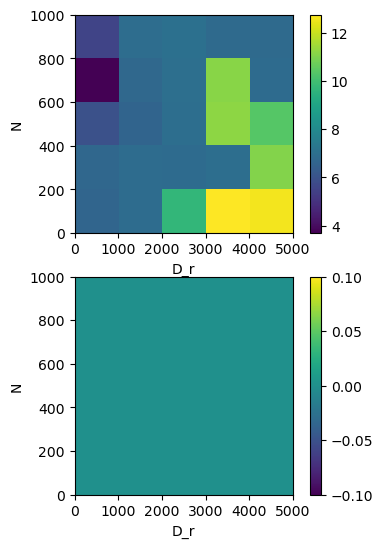

In [7]:
with open('tau_2.npy', 'rb') as f:
    Tau = np.load(f)
    
N_size = 32
N_range = 1000
Dr_size = 32
Dr_range = 5000
    
M = np.apply_along_axis(np.mean, 2, Tau)
V = np.apply_along_axis(np.var, 2, Tau)

fig, ax = plt.subplots(2, 1)

im = ax[0].imshow(M, origin='lower', extent=[0, Dr_range, 0, N_range], aspect=Dr_range/N_range)
ax[0].set_xlabel('D_r')  
ax[0].set_ylabel('N')
plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

im = ax[1].imshow(V, origin='lower', extent=[0, Dr_range, 0, N_range], aspect=Dr_range/N_range)
ax[1].set_xlabel('D_r')
ax[1].set_ylabel('N')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

plt.subplots_adjust(bottom=1e-8, right=0.8, top=1-1e-8)
plt.show()

## 